# Node/Edge Removal Analysis Notebook

This notebook mirrors the shell helpers under `analysis/`:

1. Read every `EBE_*.dat` file
2. Compute the same column-wise statistics as `statistical_analysis`
3. Extract finite-size-scaling (FSS) curves
4. Fit the power law `y = A N^\alpha` and plot

Adjust `DATA_DIR` below if your files live elsewhere.

In [39]:
from __future__ import annotations

import math
import re
from pathlib import Path
from typing import Dict, Iterable, List, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import analysis_utils as au

plt.style.use('seaborn-v0_8-colorblind')


## Paths and constants

In [40]:
ROOT_DIR = Path(__file__).resolve().parent if '__file__' in globals() else Path.cwd()
CONFIGS = {
    'node': {
        'folder': 'node_percolation',
        'file_prefix': 'NR_EBE_',
        'ci_radius': 3,
    },
    'link': {
        'folder': 'link_percolation',
        'file_prefix': 'LR_EBE_',
        'ci_radius': 0,
    },
}

DATASET = 'node'  # choose 'node' or 'link'
cfg = CONFIGS[DATASET]
DATA_DIR = ROOT_DIR / cfg['folder']
FILE_PREFIX = cfg['file_prefix']
CI_RADIUS_FILTER = cfg['ci_radius']
pat = f"{FILE_PREFIX}*.dat"
stats_name = f"stats_{FILE_PREFIX}*.dat"
OUTPUT_DIR = DATA_DIR
DATA_DIR.mkdir(parents=True, exist_ok=True)


## Column metadata

In [41]:
COLUMN_MAP = au.COLUMN_MAP
COLUMN_LOOKUP = au.COLUMN_LOOKUP


## IO helpers

## FSS extraction + power law fit

In [42]:
au.compute_effective_exponents.__doc__


'Sliding-window effective exponents via weighted log-log fits.'

## Example workflow

In [43]:
summary = au.process_all_ebe(DATA_DIR, OUTPUT_DIR, pattern=pat, ci_radius_filter=CI_RADIUS_FILTER)
summary[['file', 'ci_radius', 'M_graphs', 'runs', 'N']]


,file,ci_radius,M_graphs,runs,N
0,NR_EBE_NR_ER_N1048576_c4.00_ci_L3_Mg10000_Mr1.dat,3,10000,10000,1048576
1,NR_EBE_NR_ER_N131072_c4.00_ci_L3_Mg10000_Mr1.dat,3,10000,10000,131072
2,NR_EBE_NR_ER_N16384_c4.00_ci_L3_Mg10000_Mr1.dat,3,10000,10000,16384
3,NR_EBE_NR_ER_N16777216_c4.00_ci_L3_Mg10000_Mr1...,3,10000,10000,16777216
4,NR_EBE_NR_ER_N2097152_c4.00_ci_L3_Mg10000_Mr1.dat,3,10000,10000,2097152
5,NR_EBE_NR_ER_N262144_c4.00_ci_L3_Mg10000_Mr1.dat,3,10000,10000,262144
6,NR_EBE_NR_ER_N32768_c4.00_ci_L3_Mg10000_Mr1.dat,3,10000,10000,32768
7,NR_EBE_NR_ER_N33554432_c4.00_ci_L3_Mg1000_Mr1.dat,3,1000,1000,33554432
8,NR_EBE_NR_ER_N4096_c4.00_ci_L3_Mg10000_Mr1.dat,3,10000,10000,4096
9,NR_EBE_NR_ER_N4194304_c4.00_ci_L3_Mg10000_Mr1.dat,3,10000,10000,4194304


In [44]:
stats_files = [
    path
    for path in sorted(OUTPUT_DIR.glob(stats_name))
    if (CI_RADIUS_FILTER is None or au.extract_ci_radius(path.name) == CI_RADIUS_FILTER)
]
stats_files[:3], len(stats_files)


([PosixPath('/nfs/nfs2/home/hanlsun/global_removal/node_percolation/stats_NR_EBE_NR_ER_N1048576_c4.00_ci_L3_Mg10000_Mr1.dat'),
  PosixPath('/nfs/nfs2/home/hanlsun/global_removal/node_percolation/stats_NR_EBE_NR_ER_N131072_c4.00_ci_L3_Mg10000_Mr1.dat'),
  PosixPath('/nfs/nfs2/home/hanlsun/global_removal/node_percolation/stats_NR_EBE_NR_ER_N16384_c4.00_ci_L3_Mg10000_Mr1.dat')],
 14)

In [45]:
OBSERVABLES = [
    ("P(p+)", 4),
    ("P(q0)", 14),
]

fss_results = {}
fit_results = {}
for label, row in OBSERVABLES:
    fss = au.extract_fss(stats_files, row=row, value_kind='mean')
    fss_results[label] = fss
    fit_results[label] = au.weighted_log_fit(fss) if not fss.empty else None


/nfs/nfs2/home/hanlsun/global_removal/analysis_utils.py:237: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  value = float(row_data["mean"])
/nfs/nfs2/home/hanlsun/global_removal/analysis_utils.py:238: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  error = float(row_data["err_mean"])


In [46]:
EFFECTIVE_WINDOW = 4  # points per window for effective exponents


In [47]:
fss_results['P(p+)'], fit_results['P(p+)']


(           N        value        error  \
 0       4096    1236.9486     3.769635   
 1       8192    2109.8311     6.723093   
 2      16384    3558.2140    11.755571   
 3      32768    5942.4364    20.776280   
 4      65536    9899.8141    35.159528   
 5     131072   16102.6812    60.346544   
 6     262144   26244.7590    99.252861   
 7     524288   42568.8178   163.945054   
 8    1048576   68265.9341   269.237015   
 9    2097152  111050.8738   441.817195   
 10   4194304  177025.4657   703.442123   
 11   8388608  282154.8913  1132.553577   
 12  16777216  452161.4363  1798.322512   
 13  33554432  706245.0810  8644.771716   
 
                                                source  
 0   stats_NR_EBE_NR_ER_N4096_c4.00_ci_L3_Mg10000_M...  
 1   stats_NR_EBE_NR_ER_N8192_c4.00_ci_L3_Mg10000_M...  
 2   stats_NR_EBE_NR_ER_N16384_c4.00_ci_L3_Mg10000_...  
 3   stats_NR_EBE_NR_ER_N32768_c4.00_ci_L3_Mg10000_...  
 4   stats_NR_EBE_NR_ER_N65536_c4.00_ci_L3_Mg10000_...  
 5   stats_

In [48]:
fss_results['P(q0)'], fit_results['P(q0)']


(           N        value        error  \
 0       4096     752.3434     3.255133   
 1       8192    1268.4044     5.640578   
 2      16384    2140.5732     9.778703   
 3      32768    3562.8934    17.094634   
 4      65536    5926.6074    28.576576   
 5     131072    9679.1154    48.798866   
 6     262144   15680.0588    79.533551   
 7     524288   25314.2515   129.909078   
 8    1048576   40284.9576   210.074144   
 9    2097152   65078.4400   343.333692   
 10   4194304  103758.1874   547.981855   
 11   8388608  163826.7906   861.022203   
 12  16777216  261497.5095  1374.242788   
 13  33554432  421115.7790  6778.805299   
 
                                                source  
 0   stats_NR_EBE_NR_ER_N4096_c4.00_ci_L3_Mg10000_M...  
 1   stats_NR_EBE_NR_ER_N8192_c4.00_ci_L3_Mg10000_M...  
 2   stats_NR_EBE_NR_ER_N16384_c4.00_ci_L3_Mg10000_...  
 3   stats_NR_EBE_NR_ER_N32768_c4.00_ci_L3_Mg10000_...  
 4   stats_NR_EBE_NR_ER_N65536_c4.00_ci_L3_Mg10000_...  
 5   stats_

## Giant component vs removed fraction

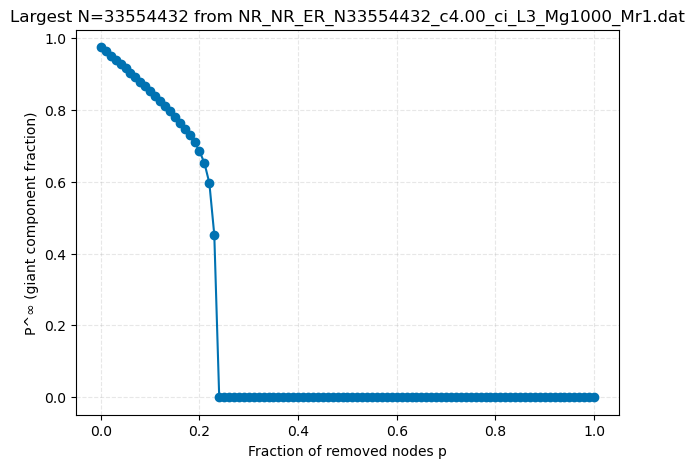

In [49]:
au.plot_giant_component_vs_p(DATA_DIR, FILE_PREFIX, CI_RADIUS_FILTER)


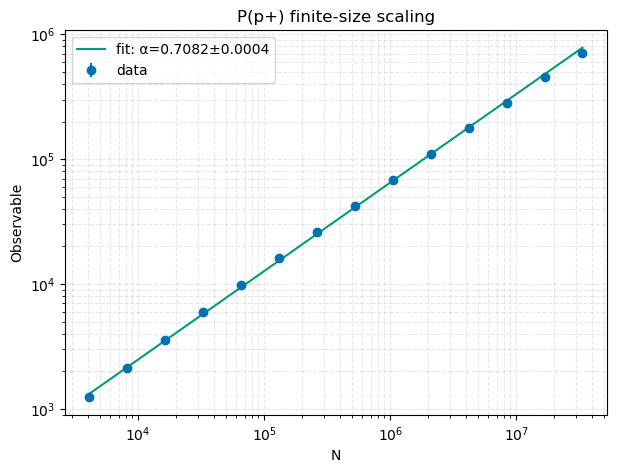

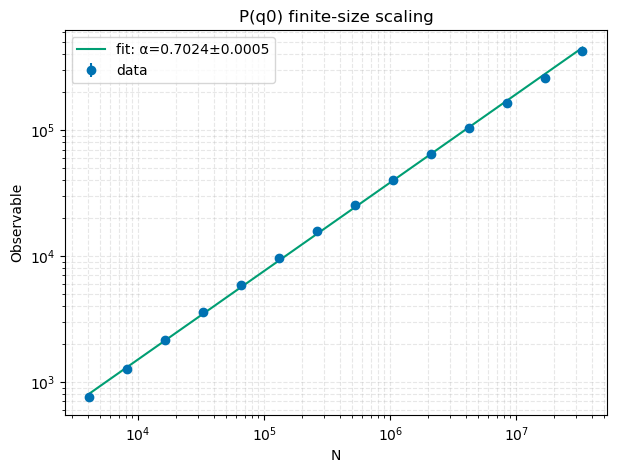

In [50]:
for label, _ in OBSERVABLES:
    fss = fss_results[label]
    fit = fit_results[label]
    if fss.empty or fit is None:
        print(f'No data for {label}')
        continue
    au.plot_fss_with_fit(fss, fit, title=f"{label} finite-size scaling")


/nfs/nfs2/home/hanlsun/global_removal/analysis_utils.py:237: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  value = float(row_data["mean"])
/nfs/nfs2/home/hanlsun/global_removal/analysis_utils.py:238: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  error = float(row_data["err_mean"])


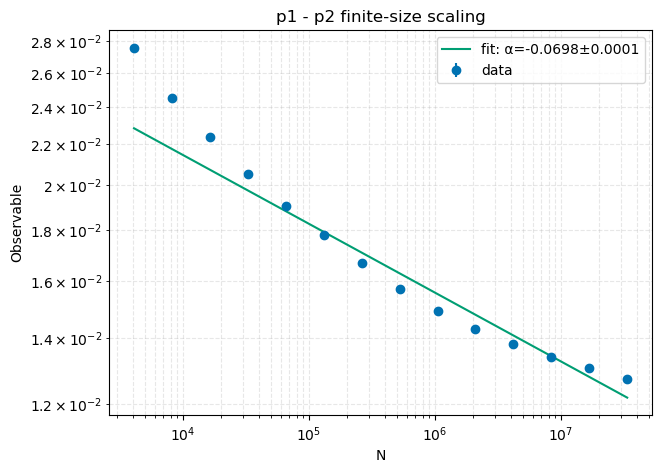

In [51]:
fss_gap = au.extract_p1_minus_p2(stats_files, value_kind='mean')
fit_gap = au.weighted_log_fit(fss_gap)
au.plot_fss_with_fit(fss_gap, fit_gap, title='p1 - p2 finite-size scaling')


In [52]:
effective_results = {}
for label, _ in OBSERVABLES:
    fss = fss_results[label]
    if fss.empty:
        effective_results[label] = pd.DataFrame()
    else:
        effective_results[label] = au.compute_effective_exponents(fss, window=EFFECTIVE_WINDOW)


In [53]:
effective_results['P(p+)']


,N_left,N_right,N_geom,exponent,exponent_err
0,4096.0,32768.0,1.158524e+04,0.755258,0.002106
1,8192.0,65536.0,2.317048e+04,0.743317,0.002175
2,16384.0,131072.0,4.634095e+04,0.727741,0.002271
3,32768.0,262144.0,9.268190e+04,0.713354,0.002348
4,65536.0,524288.0,1.853638e+05,0.701806,0.002391
5,131072.0,1048576.0,3.707276e+05,0.695099,0.002479
6,262144.0,2097152.0,7.414552e+05,0.692458,0.002504
7,524288.0,4194304.0,1.482910e+06,0.687024,0.002527
8,1048576.0,8388608.0,2.965821e+06,0.681527,0.002567
9,2097152.0,16777216.0,5.931642e+06,0.674944,0.002567


In [54]:
effective_results['P(q0)']


,N_left,N_right,N_geom,exponent,exponent_err
0,4096.0,32768.0,1.158524e+04,0.748850,0.002938
1,8192.0,65536.0,2.317048e+04,0.740978,0.002993
2,16384.0,131072.0,4.634095e+04,0.726872,0.003097
3,32768.0,262144.0,9.268190e+04,0.712344,0.003184
4,65536.0,524288.0,1.853638e+05,0.698155,0.003215
5,131072.0,1048576.0,3.707276e+05,0.686410,0.003307
6,262144.0,2097152.0,7.414552e+05,0.683000,0.003338
7,524288.0,4194304.0,1.482910e+06,0.679726,0.003362
8,1048576.0,8388608.0,2.965821e+06,0.674494,0.003380
9,2097152.0,16777216.0,5.931642e+06,0.667860,0.003397


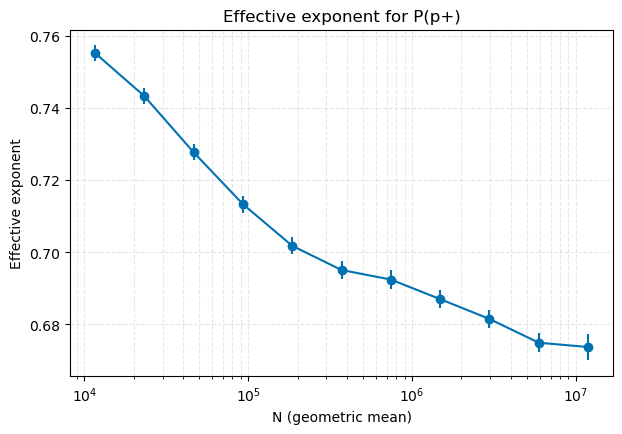

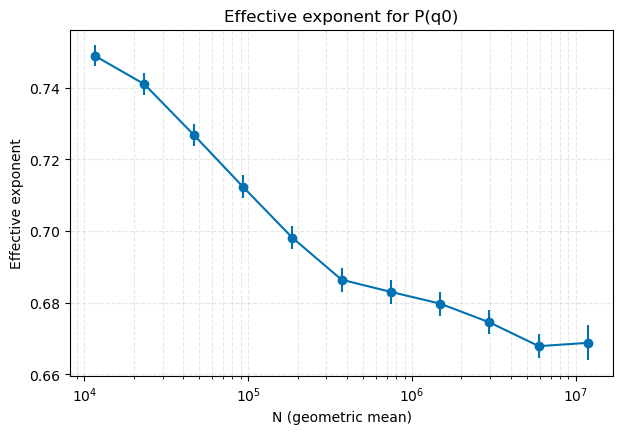

In [55]:
for label, _ in OBSERVABLES:
    eff = effective_results[label]
    if eff.empty:
        print(f'No effective exponents for {label}')
        continue
    au.plot_effective_exponent(eff, title=f"Effective exponent for {label}")


## Jump-height scaling

Plot the normalized jump height dP(p+) versus system size and fit a power law in log-log space.

/nfs/nfs2/home/hanlsun/global_removal/analysis_utils.py:237: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  value = float(row_data["mean"])
/nfs/nfs2/home/hanlsun/global_removal/analysis_utils.py:238: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  error = float(row_data["err_mean"])


           N     value     error
0       4096  0.097930  0.000349
1       8192  0.080260  0.000301
2      16384  0.066343  0.000252
3      32768  0.053743  0.000213
4      65536  0.043466  0.000171
5     131072  0.034826  0.000140
6     262144  0.028079  0.000115
7     524288  0.022752  0.000094
8    1048576  0.017927  0.000074
9    2097152  0.014366  0.000059
10   4194304  0.011482  0.000048
11   8388608  0.009089  0.000037
12  16777216  0.007253  0.000030
13  33554432  0.005832  0.000076
Jump-height fit: {'A': 1.3848772286020632, 'A_err': 0.007204141417973163, 'alpha': np.float64(-0.3140355709518856), 'alpha_err': 0.00041356062762262026, 'chi2_red': 28.730494621195955, 'fit_used_abs': False, 'fit_value_sign': 1.0}


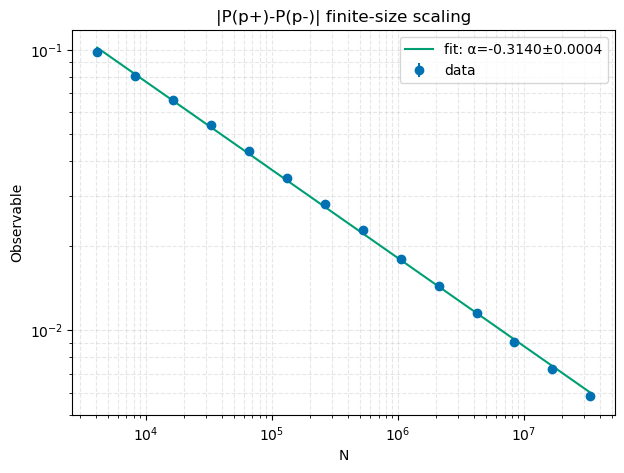

In [56]:
jump_fss = au.extract_fss(stats_files, row=3, value_kind='mean')
if jump_fss.empty:
    print('No jump-height data found; regenerate stats with updated binaries.')
else:
    jump_fit = au.weighted_log_fit(jump_fss)
    print(jump_fss[['N', 'value', 'error']])
    print('Jump-height fit:', jump_fit)
    au.plot_fss_with_fit(jump_fss, jump_fit, title='|P(p+)-P(p-)| finite-size scaling')


## Jump-height effective exponent

Local effective exponent for dP(p+) using the configured window.


       N_left     N_right        N_geom  exponent  exponent_err
0      4096.0     32768.0  1.158524e+04 -0.286933      0.002425
1      8192.0     65536.0  2.317048e+04 -0.295640      0.002480
2     16384.0    131072.0  4.634095e+04 -0.309417      0.002528
3     32768.0    262144.0  9.268190e+04 -0.312945      0.002591
4     65536.0    524288.0  1.853638e+05 -0.311352      0.002601
5    131072.0   1048576.0  3.707276e+05 -0.317699      0.002631
6    262144.0   2097152.0  7.414552e+05 -0.324402      0.002642
7    524288.0   4194304.0  1.482910e+06 -0.327963      0.002672
8   1048576.0   8388608.0  2.965821e+06 -0.326328      0.002651
9   2097152.0  16777216.0  5.931642e+06 -0.329473      0.002668
10  4194304.0  33554432.0  1.186328e+07 -0.329745      0.003881


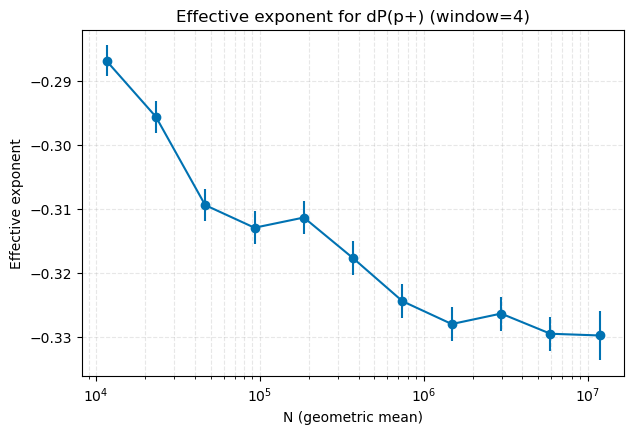

In [57]:
jump_eff = pd.DataFrame()
if 'jump_fss' not in globals():
    print('jump_fss not defined; run the jump-height cell first.')
elif jump_fss.empty:
    print('No effective exponents for jump height')
else:
    jump_eff = au.compute_effective_exponents(jump_fss, window=EFFECTIVE_WINDOW)
    print(jump_eff)
    au.plot_effective_exponent(jump_eff, title=f'Effective exponent for dP(p+) (window={EFFECTIVE_WINDOW})')
